In [232]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

In [233]:
mnist = fetch_openml("mnist_784")
X, y = mnist["data"].to_numpy().reshape(-1, 28, 28).astype(float), mnist[
    "target"
].to_numpy().astype(int)
X[X <= 127] = 0.0
X[X > 127] = 1.0
n = X.shape[1] * X.shape[2]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print(X_train.data.shape)
# Shape information
H, W = X_train.shape[1], X_train.shape[2]  # Height and Width

(63000, 28, 28)


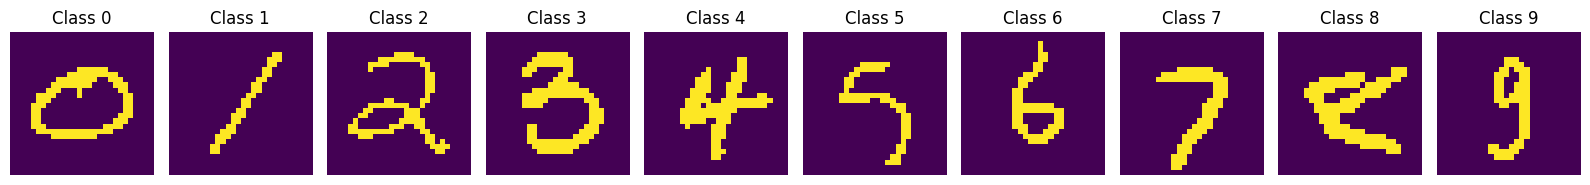

In [234]:
def plot_digits(X_train, y_train, num_classes=10):
    fig, axes = plt.subplots(1,num_classes, figsize=(16, 6))

    for cls in range(num_classes):
        # Select a random image from the class
        class_indices = np.where(y_train == cls)[0]
        random_index = np.random.choice(class_indices)
        random_image = X_train[random_index]

        # Plot the random image
        axes[cls].imshow(random_image)
        axes[cls].set_title(f"Class {cls}")
        axes[cls].axis("off")

    plt.tight_layout()

plot_digits(X_train, y_train)

In [235]:
# Helper function for Laplace smoothing
def laplace_smoothing(count, total, alpha=1, coef=2):
    return (count + alpha) / (total + coef * alpha)


# Naive Bayes Classifier
class NaiveBayesClassifier:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.P_y = None
        self.P_xy = None

    def train(self, X, y):
        print("Training NaiveBayes...")
        n_samples, H, W = X.shape[0], X.shape[1], X.shape[2]
        self.P_y = np.random.randn(self.num_classes)
        self.P_xy = np.random.randn(self.num_classes, H, W)

        # TODO: Compute P(y) and P(x|y)
        # computing number of occurences of each class
        classes, count = np.unique(y, return_counts=True)
        self.P_y = count / n_samples # number of occurences of class k /total samples = prior prob of class k


        # estimations of conditional probabilities
        for k in classes:
            # only samples of class k
            filter_arr = y == k  
            X_class_k = X[filter_arr,:,:]

            active_counts = np.sum(X_class_k, axis=0)
            self.P_xy[k,:,:] = laplace_smoothing(count=active_counts, total=X_class_k.shape[0])

    def predict(self, X):
        print("TEsting NaiveBayes...")
        predictions = np.random.randint(0,high=self.num_classes, size=X.shape[0])
        # TODO: Compute predictions
        n_samples, H, W = X.shape[0], X.shape[1], X.shape[2]
        
        
        # #----------------------------- WAY 1 -----------------------------
        # for image in range(n_samples):
        #     y_ = (np.log(self.P_y).reshape(-1,1) + np.log(self.P_xy).reshape(-1, 28**2) @ X[image,:,:].flatten().reshape(-1,1) + np.log(1-self.P_xy).reshape(-1, 28**2) @ (1-X[image,:,:].flatten().reshape(-1,1))).reshape(10,)   
        #     prediction = np.argmax(y_)
        #     predictions[image] = prediction


        # ----------------------------- WAY 2, vectorized ---------------------------------------:
        log_P_y = np.log(self.P_y).reshape(-1,1) # (10, 1)
        log_P_xy_flat = np.log(self.P_xy).reshape(-1, H*W) # (10, 784)
        log_1_minus_P_xy_flat = np.log(1-self.P_xy).reshape(-1, H*W) # (10, 784)
        X_flat = X.reshape(-1, H*W) # (n_samples, H*W)

        # want output in form: (n_samples,10) => log_P_y + X @ P_xy = shapes: (1,10) + (n_samples, H*W) @ (H*W, 10) + ...
        y_ = (
            log_P_y.T # shape: (1,10)
            + X_flat @ log_P_xy_flat.T  # shape: (n_samples, H*W) @ (H*W, 10) = (n_samples, H*W)
            + (1-X_flat) @ log_1_minus_P_xy_flat.T # shape: (n_samples, H*W) @ (H*W, 10) = (n_samples, H*W)
            )
        
        predictions = np.argmax(y_, axis=1) # shape: (n_samples,)

        return predictions

In [236]:
# Logistic Regression Classifier
class LogisticRegressionClassifier:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.lr_model = LogisticRegression(max_iter=1000, solver='lbfgs') # TODO: Initialize your logistic regression model here

    def train(self, X, y):
        print("Training logistic regression...")
        # Todo: Train your logistic regression model here
        self.lr_model.fit(X, y)

    def predict(self, X):
        print("Predicting with logistic regression...")
        predictions = np.random.randint(0,high=self.num_classes, size=X.shape[0])
        # TODO: Compute predictions
        predictions = self.lr_model.predict(X)

        return predictions
    
    def get_weights(self):
        if self.lr_model is None:
            return None
        return self.lr_model.coef_ # This is For visualization purposes only

In [237]:
# Train and Evaluate Naive Bayes Classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.train(X_train, y_train)
nb_preds = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_preds)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")

# want to see performance on train data too to evaluate bias and variance.
nb_preds_train = nb_classifier.predict(X_train)
nb_accuracy_train = accuracy_score(y_train, nb_preds_train)
print(f"Naive Bayes Accuracy (training set): {nb_accuracy_train * 100:.2f}%")

# Train and Evaluate Logistic Regression Classifier
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train.reshape(-1, n))
X_test_lr = scaler.transform(X_test.reshape(-1, n))
lr_classifier = LogisticRegressionClassifier()
lr_classifier.train(X_train_lr, y_train)
lr_preds = lr_classifier.predict(X_test_lr)
lr_accuracy = accuracy_score(y_test, lr_preds)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")

# performance on training data:
lr_preds_train = lr_classifier.predict(X_train_lr)
lr_accuracy_train = accuracy_score(y_train, lr_preds_train)
print(f"Logistic Regression Accuracy (training set): {lr_accuracy_train * 100:.2f}%")


Training NaiveBayes...
TEsting NaiveBayes...
Naive Bayes Accuracy: 83.59%
TEsting NaiveBayes...
Naive Bayes Accuracy (training set): 83.67%
Logistic Regression Accuracy (training set): 93.79%


TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...
TEsting NaiveBayes...


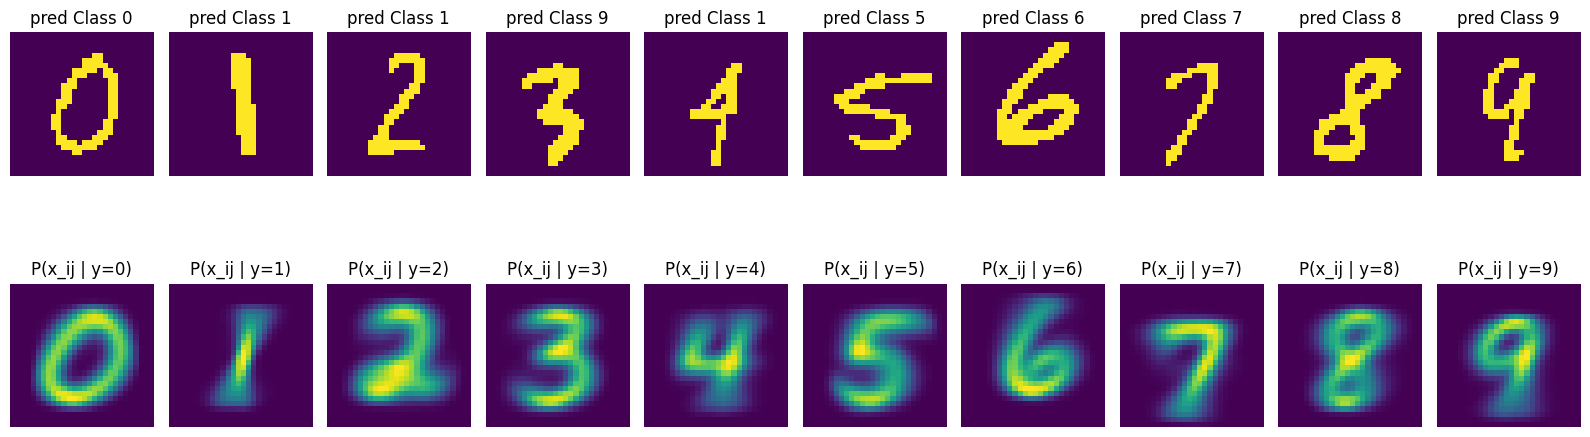

In [243]:
# Function to plot a random image and its corresponding P_xy for each class
def plot_random_image_and_p_xy(nb_classifier, X_test, y_test, num_classes=10):
    fig, axes = plt.subplots(2, num_classes, figsize=(16, 6))

    for cls in range(num_classes):
        # Select a random image from the class
        class_indices = np.where(y_test == cls)[0]
        random_index = np.random.choice(class_indices)
        random_image = X_test[random_index]
        prediction = nb_classifier.predict(random_image.reshape(1, H, W))[0]

        # Plot the random image
        axes[0, cls].imshow(random_image)
        axes[0, cls].set_title(f"pred Class {int(prediction)}")
        axes[0, cls].axis("off")

        # Plot the P_xy for the class
        axes[1, cls].imshow(nb_classifier.P_xy[cls])
        axes[1, cls].set_title(f"P(x_ij | y={cls})")
        axes[1, cls].axis("off")
    plt.tight_layout()

# Example usage
plot_random_image_and_p_xy(nb_classifier, X_train, y_train)

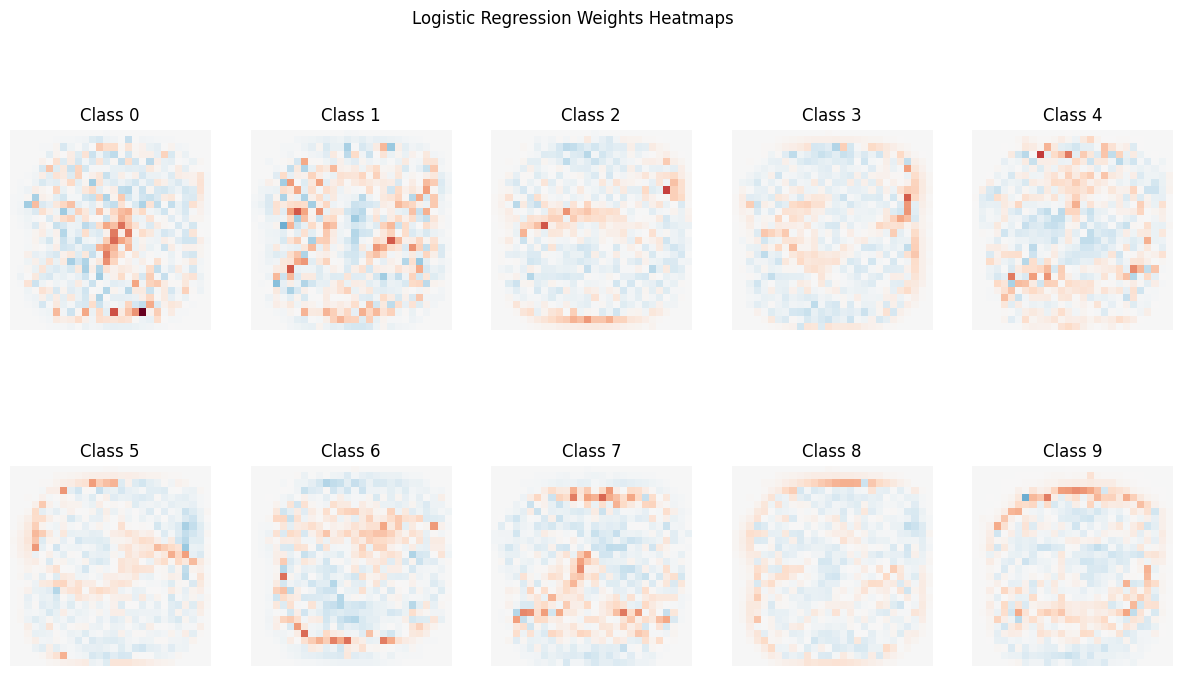

In [239]:
# Visualize weights for each class
coef = lr_classifier.get_weights()
if coef is None:
    print("No weights found")
    coef = np.random.randn(10, 28, 28)
weights = coef.reshape(10, 28, 28)
scale = np.abs(coef).max()

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        weights[i],
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    plt.title(f"Class {i}")
    plt.axis("off")
plt.suptitle("Logistic Regression Weights Heatmaps")
plt.show()